# Cryptocurrency Price Prediction with AUTO TS

>Development of a model to predict Bitcoin prices with machine learning using AUTO TS. The data was splited into train and test (considering 90:10 ratio) and evaluated by MAPE (Mean Absolute Percentage Error). To simplify the model, was considered historical prices from YFinance since 2021.
Source: https://finance.yahoo.com/

**Disclaimer:**
This Cryptocurrency Prediction Model can only work in situations where prices changes due to historical variation. Any other price variation reasons, such as government regulations, changes in financial policies, etc do not impact the presented predictions.

In [169]:
# Import modules:
import pandas as pd
import numpy as np
from autots import AutoTS
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
import datetime
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import seaborn as sns
%matplotlib inline

### Colect and process Bitcoin prices data from yfinance API:

In [230]:
# Getting data from yfinance API (https://pypi.org/project/yfinance/):
btc = yf.Ticker('BTC-USD')

In [231]:
# Creating history price data frame since 2021:
df_btc = btc.history(start="2021-01-01")

In [232]:
# Adding column with date information and reset index:
df_btc['date'] = df_btc.index
df_btc.reset_index(drop=True, inplace=True)

In [233]:
# Renaming columns:
df_btc.rename(columns= str.lower, inplace = True)

In [234]:
# Rearranging columns order:
df_btc = df_btc[['date','open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits']]

In [235]:
# Date converting type:
df_btc.date = pd.to_datetime(df_btc.date)

In [236]:
# Printting first ten rows:
df_btc.head(10)

,date,open,high,low,close,volume,dividends,stock splits
0,2021-01-01 00:00:00+00:00,28994.009766,29600.626953,28803.585938,29374.152344,40730301359,0.0,0.0
1,2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0.0,0.0
2,2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0.0,0.0
3,2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,0.0,0.0
4,2021-01-05 00:00:00+00:00,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,0.0,0.0
5,2021-01-06 00:00:00+00:00,34013.613281,36879.699219,33514.035156,36824.363281,75289433811,0.0,0.0
6,2021-01-07 00:00:00+00:00,36833.875000,40180.367188,36491.191406,39371.042969,84762141031,0.0,0.0
7,2021-01-08 00:00:00+00:00,39381.765625,41946.738281,36838.636719,40797.609375,88107519480,0.0,0.0
8,2021-01-09 00:00:00+00:00,40788.640625,41436.351562,38980.875000,40254.546875,61984162837,0.0,0.0
9,2021-01-10 00:00:00+00:00,40254.218750,41420.191406,35984.628906,38356.441406,79980747690,0.0,0.0


In [237]:
# Checking missing values:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          745 non-null    datetime64[ns, UTC]
 1   open          745 non-null    float64            
 2   high          745 non-null    float64            
 3   low           745 non-null    float64            
 4   close         745 non-null    float64            
 5   volume        745 non-null    int64              
 6   dividends     745 non-null    float64            
 7   stock splits  745 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 46.7 KB


### Candlestick chart to visualize Bitcoin Prices and the Simple Moving Average since 2022, July:

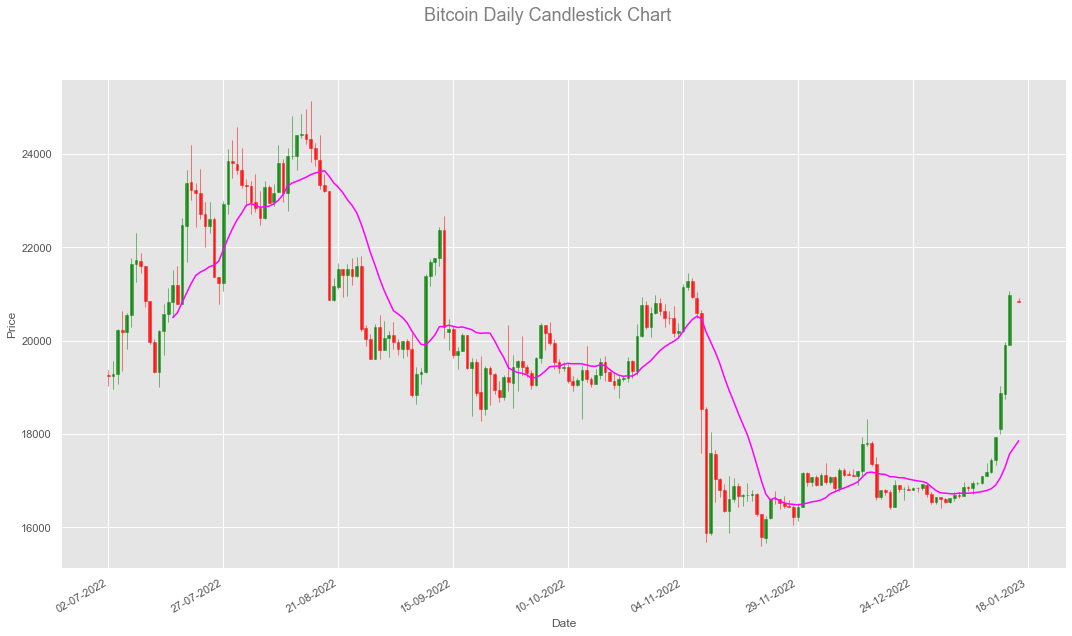

In [284]:
plt.style.use('ggplot')

# Selecting and preparing data:
ohlc = df_btc.loc[df_btc.date > "2022-07-01", ['date', 'open', 'high', 'low', 'close']]
ohlc.date = ohlc.date.apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Including Simple Moving Average (SMA) for 15 days.
ohlc['sma5'] = ohlc.close.rolling(15).mean() 

# Creating subplots:
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8 )
ax.plot(ohlc.date, ohlc['sma5'], color='Fuchsia')

# Setting labels, title and size:
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Bitcoin Daily Candlestick Chart', fontsize=18, color='Grey')
fig.set_size_inches(18, 10)

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.show()

### Splitting train and test data:

In [280]:
# Using just the feature named "close" which is the daily closing price:
df = df_btc[["date", "close"]]

In [281]:
# Sortting values by date:
df = df.sort_values('date')

In [282]:
# Using ratio 90:10 to split test and train data. It means 90% of the data for training and 10% for test:
count_lines = df.shape[0]
limit = int(count_lines*0.9)

In [283]:
# Splitting train-test dataset:
train = df.iloc[:limit]
test = df.iloc[limit:]

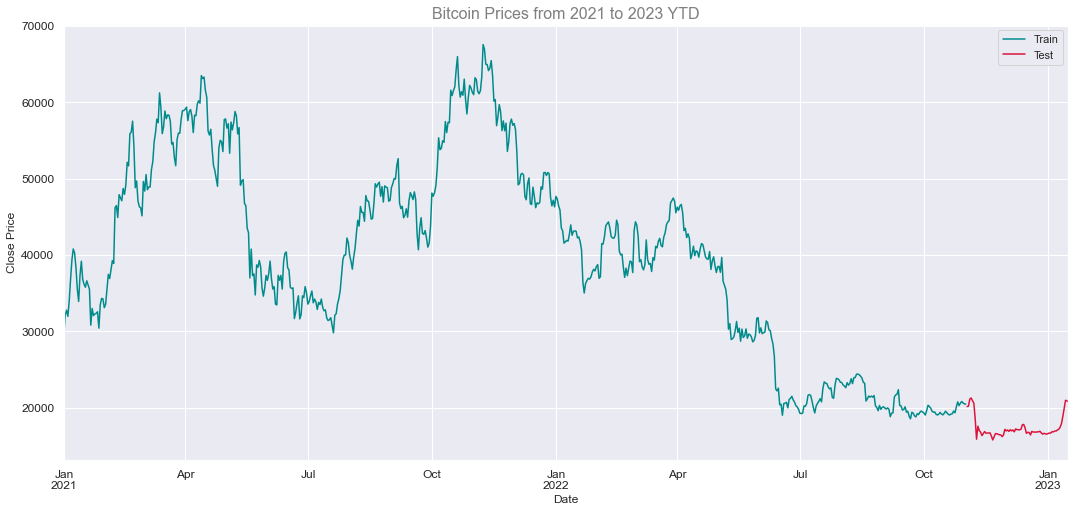

In [285]:
# Line Chart to visualize train-test dataset:
train_graph = train.set_index('date')
test_graph = test.set_index('date')

sns.set_theme()
train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
plt.legend()
plt.title("Bitcoin Prices from 2021 to 2023 YTD", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

### Model Building using AUTO TS:

In [246]:
# Setting model parameters: 
model = AutoTS(forecast_length=test.shape[0],frequency='infer', ensemble='simple')

In [248]:
# Fitting model:
model = model.fit(train, date_col='date', value_col='close', id_col=None)

Inferred frequency is: D
Model Number: 1 with model ARIMA in generation 0 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Model Number: 2 with model ARIMA in generation 0 of 10
Model Number: 3 with model ARIMA in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model AverageValueNaive in generation 0 of 10
Model Number: 6 with model AverageValueNaive in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Model Number: 8 with model DatepartRegression in generation 0 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 9 with model DatepartRegression in generation 0 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 10 with model DatepartRegression in generation 0 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 10: DatepartRegression
Model Number: 11 with model ETS in generation 0 of 10
Model Number: 12 with model ETS in generation 0 of 10
Model Number: 13 with model GLM in generation 0 of 10
Model Number: 14 with model GLM in generation 0 of 10
Model Number: 15 with model GLS in generation 0 of 10
Model Number: 16 with model GLS in generation 0 of 10
Model Number: 17 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 17: GluonTS
Model Number: 18 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 18: GluonTS
Model Number: 19 with model GluonTS in generation 0 of 10
Template Eval Error: Impor

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3183: RuntimeWarning: divide by zero encountered in power
  x_inv[~pos] = 1 - np.power(-(2 - lmbda) * x[~pos] + 1,
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3183: RuntimeWarning: divide by zero encountered in power
  x_inv[~pos] = 1 - np.power(-(2 - lmbda) * x[~pos] + 1,
c:\Users\gbezerr\Anaconda3\lib\site-packages\

Model Number: 27 with model SeasonalNaive in generation 0 of 10
Model Number: 28 with model SeasonalNaive in generation 0 of 10
Model Number: 29 with model UnobservedComponents in generation 0 of 10
Model Number: 30 with model UnobservedComponents in generation 0 of 10
Model Number: 31 with model UnobservedComponents in generation 0 of 10
Model Number: 32 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 32: VAR
Model Number: 33 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 33: VAR
Model Number: 34 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 34: VECM
Model Number: 35 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 35: VECM
Model Number: 36 with model WindowRegression in generation 0 of 10
Model Number: 37 with model ConstantNaive 

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 38 with model FBProphet in generation 0 of 10
Template Eval Error: ValueError('Column ds has timezone specified, which is not supported. Remove timezone.') in model 38: FBProphet
Model Number: 39 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 39: GluonTS
Model Number: 40 with model MultivariateRegression in generation 0 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 41 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 41: MultivariateRegression
Model Number: 42 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 42: DatepartRegression
Model Number: 43 with model SeasonalNaive in generation 0 of 10
Model Number: 44 with model DatepartRegression in generation 0 of 10
Model Number: 45 with model UnobservedComponents in generation 0 of 10
Model Number: 46 with model UnobservedComponents in generation 0 of 10
Model Number: 47 with model ETS in generation 0 of 10
Model Number: 48 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 48: VECM
Model Number: 49 with model ARDL in generation 0 of 10
Model Number: 50 with model MultivariateMotif in generation 0 of 10
Model Number: 51 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 60 with model NVAR in generation 0 of 10
Model Number: 61 with model Theta in generation 0 of 10
Model Number: 62 with model UnivariateRegression in generation 0 of 10
Model Number: 63 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 63: ARCH
Model Number: 64 with model ConstantNaive in generation 0 of 10
Model Number: 65 with model LastValueNaive in generation 0 of 10
Model Number: 66 with model AverageValueNaive in generation 0 of 10
Model Number: 67 with model GLS in generation 0 of 10
Model Number: 68 with model SeasonalNaive in generation 0 of 10
Model Number: 69 with model GLM in generation 0 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 69: GLM
Model Number: 70 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with Valu

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 91: DatepartRegression
Model Number: 92 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 92: VAR
Model Number: 93 with model UnivariateMotif in generation 0 of 10
Model Number: 94 with model UnivariateRegression in generation 0 of 10
Model Number: 95 with model AverageValueNaive in generation 0 of 10
Model Number: 96 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 96: VAR
Model Number: 97 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 97: DatepartRegression
Model Number: 98 with model MetricMotif in generation 0 of 10
Model Number: 99 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 123 with model Theta in generation 0 of 10
Model Number: 124 with model MultivariateMotif in generation 0 of 10
Model Number: 125 with model UnivariateMotif in generation 0 of 10
Model Number: 126 with model GLM in generation 0 of 10
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 126: GLM
Model Number: 127 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 127: ARIMA
Model Number: 128 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 128: VAR
Model Number: 129 with model Theta in generation 0 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 130 with model SeasonalNaive in generation 0 of 10
Model Number: 131 with model SeasonalNaive in generation 0 of 10
Model Number: 132 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 132: ARCH
Model Number: 133 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 133: VECM
Model Number: 134 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 134: VAR
Model Number: 135 with model MetricMotif in generation 0 of 10
Model Number: 136 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 136: VECM
Model Number: 137 with model ETS in generation 0 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 180 with model UnobservedComponents in generation 0 of 10
Model Number: 181 with model SeasonalNaive in generation 0 of 10
Model Number: 182 with model LastValueNaive in generation 0 of 10
Model Number: 183 with model DatepartRegression in generation 0 of 10
Model Number: 184 with model ARIMA in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 184: ARIMA
Model Number: 185 with model MultivariateRegression in generation 0 of 10
Model Number: 186 with model AverageValueNaive in generation 0 of 10
Model Number: 187 with model ETS in generation 0 of 10
Model Number: 188 with model ETS in generation 0 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
ETS failed on close with ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')
New Generation: 1 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 190 with model MetricMotif in generation 1 of 10
Model Number: 191 with model UnivariateMotif in generation 1 of 10
Model Number: 192 with model GLM in generation 1 of 10
Model Number: 193 with model MultivariateMotif in generation 1 of 10
Model Number: 194 with model ConstantNaive in generation 1 of 10
Model Number: 195 with model ETS in generation 1 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 196 with model MetricMotif in generation 1 of 10
Model Number: 197 with model MetricMotif in generation 1 of 10
Model Number: 198 with model Theta in generation 1 of 10
Model Number: 199 with model UnivariateRegression in generation 1 of 10
Model Number: 200 with model MultivariateMotif in generation 1 of 10
Model Number: 201 with model DatepartRegression in generation 1 o

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 205 with model ETS in generation 1 of 10
Model Number: 206 with model LastValueNaive in generation 1 of 10
Model Number: 207 with model SeasonalNaive in generation 1 of 10
Model Number: 208 with model MultivariateRegression in generation 1 of 10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\gbezerr\Anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\gbezerr\Anaconda3\lib\site-packages\numpy\lib\function_base.py:527: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


Model Number: 249 with model NVAR in generation 1 of 10
Model Number: 250 with model Theta in generation 1 of 10
Model Number: 251 with model SeasonalNaive in generation 1 of 10
Model Number: 252 with model MultivariateMotif in generation 1 of 10
Model Number: 253 with model ETS in generation 1 of 10
Model Number: 254 with model ARIMA in generation 1 of 10
Model Number: 255 with model GLM in generation 1 of 10
Model Number: 256 with model NVAR in generation 1 of 10
Model Number: 257 with model Theta in generation 1 of 10
Model Number: 258 with model SectionalMotif in generation 1 of 10
Model Number: 259 with model GLM in generation 1 of 10
Model Number: 260 with model GLM in generation 1 of 10
Model Number: 261 with model UnobservedComponents in generation 1 of 10
Model Number: 262 with model Theta in generation 1 of 10
Model Number: 263 with model MultivariateRegression in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") i

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 275 with model LastValueNaive in generation 1 of 10
Model Number: 276 with model GLM in generation 1 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 276: GLM
Model Number: 277 with model LastValueNaive in generation 1 of 10
Model Number: 278 with model ETS in generation 1 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 279 with model SeasonalNaive in generation 1 of 10
Model Number: 280 with model AverageValueNaive in generation 1 of 10
Model Number: 281 with model Theta in generation 1 of 10
Model Number: 282 with model MultivariateMotif in generation 1 of 10
Model Number: 283 with model MetricMotif in generation 1 of 10
Model Number: 284 with model GLS in generation 1 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 284: GLS
Model Number: 285 with model NVAR in generation 1 of 10
Model Number: 286 with model LastValueNaive in generation 1 of 10
Model Number: 287 with model MetricMotif in generation 1 of 10
Model Number: 288 with model UnivariateMotif in generation 1 of 10
Model Number: 289 with model UnivariateMotif in generation 1 of 10
Model Number: 290 with model ARIMA in generation 1 of 10
Model Number: 291 with model MultivariateRegression in generation 1 of 10
Model Number: 292 with model LastValueNaive in generation 1 of 10
Model Number: 293 with 

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 323 with model UnobservedComponents in generation 2 of 10
Model Number: 324 with model MultivariateMotif in generation 2 of 10
Model Number: 325 with model SectionalMotif in generation 2 of 10
Model Number: 326 with model AverageValueNaive in generation 2 of 10
Model Number: 327 with model UnivariateMotif in generation 2 of 10
Model Number: 328 with model NVAR in generation 2 of 10
Model Number: 329 with model Theta in generation 2 of 10
Model Number: 330 with model UnivariateMotif in generation 2 of 10
Model Number: 331 with model ARIMA in generation 2 of 10
Model Number: 332 with model GLM in generation 2 of 10
Model Number: 333 with model SeasonalNaive in generation 2 of 10
Model Number: 334 with model MultivariateMotif in generation 2 of 10
Model Number: 335 with model ConstantNaive in generation 2 of 10
Model Number: 336 with model MultivariateRegression in generation 2 of 10
Model Number: 337 with model SeasonalNaive in generation 2 of 10
Model Number: 338 with mode

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79367e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Model Number: 364 with model UnivariateMotif in generation 2 of 10
Model Number: 365 with model ARIMA in generation 2 of 10
Model Number: 366 with model DatepartRegression in generation 2 of 10
Model Number: 367 with model Theta in generation 2 of 10
Model Number: 368 with model MultivariateMotif in generation 2 of 10
Model Number: 369 with model LastValueNaive in generation 2 of 10
Model Number: 370 with model ARIMA in generation 2 of 10
Model Number: 371 with model UnobservedComponents in generation 2 of 10
Model Number: 372 with model ARIMA in generation 2 of 10
Model Number: 373 with model ConstantNaive in generation 2 of 10
Model Number: 374 with model SectionalMotif in generation 2 of 10
Model Number: 375 with model NVAR in generation 2 of 10
Model Number: 376 with model MultivariateRegression in generation 2 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 377 with model UnivariateMotif in generation 2 of 10
Model Number: 378 with model LastValueNaive in generation 2 of 10
Model Number: 379 with model ConstantNaive in generation 2 of 10
Model Number: 380 with model Theta in generation 2 of 10
Model Number: 381 with model LastValueNaive in generation 2 of 10
Model Number: 382 with model SectionalMotif in generation 2 of 10
Model Number: 383 with model LastValueNaive in generation 2 of 10
Model Number: 384 with model UnobservedComponents in generation 2 of 10
Model Number: 385 with model UnivariateMotif in generation 2 of 10
Model Number: 386 with model MetricMotif in generation 2 of 10
Model Number: 387 with model AverageValueNaive in generation 2 of 10
Model Number: 388 with model MultivariateRegression in generation 2 of 10
Model Number: 389 with model WindowRegression in generation 2 of 10
Model Number: 390 with model Theta in generation 2 of 10
Model Number: 391 with model ARIMA in generation 2 of 10
Model Number: 392 wi

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 395 with model LastValueNaive in generation 2 of 10
Model Number: 396 with model MultivariateMotif in generation 2 of 10
Model Number: 397 with model LastValueNaive in generation 2 of 10
Model Number: 398 with model LastValueNaive in generation 2 of 10
Model Number: 399 with model ETS in generation 2 of 10
Model Number: 400 with model NVAR in generation 2 of 10
Model Number: 401 with model MetricMotif in generation 2 of 10
Model Number: 402 with model WindowRegression in generation 2 of 10
Model Number: 403 with model UnivariateMotif in generation 2 of 10
Model Number: 404 with model ConstantNaive in generation 2 of 10
Model Number: 405 with model SeasonalNaive in generation 2 of 10
Model Number: 406 with model NVAR in generation 2 of 10
Model Number: 407 with model MultivariateMotif in generation 2 of 10
Model Number: 408 with model LastValueNaive in generation 2 of 10
Model Number: 409 with model ConstantNaive in generation 2 of 10
Model Number: 410 with model Multivari

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 411 with model LastValueNaive in generation 2 of 10
Model Number: 412 with model MultivariateRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 413 with model GLS in generation 2 of 10
Model Number: 414 with model WindowRegression in generation 2 of 10
Model Number: 415 with model Theta in generation 2 of 10
Model Number: 416 with model GLM in generation 2 of 10
Model Number: 417 with model SeasonalNaive in generation 2 of 10
Model Number: 418 with model Theta in generation 2 of 10
Model Number: 419 with model MultivariateMotif in generation 2 of 10
Model Number: 420 with model NVAR in generation 2 of 10
Model Number: 421 with model SeasonalNaive in generation 2 of 10
Model Number: 422 with model ETS in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 422: ETS
Model Number: 423 with model GLM in generation 2 of 10
Model Number: 424 with model ETS in generation 2 of 10
Model Number: 425 with model Theta in generation 2 of 10
Model Number: 426 with model MetricMotif in generation 2 of 10
Model Number: 427 with model WindowRegression in generation 2 of 10
Model Nu

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 429 with model AverageValueNaive in generation 2 of 10
Model Number: 430 with model AverageValueNaive in generation 2 of 10
Model Number: 431 with model UnobservedComponents in generation 2 of 10
Model Number: 432 with model ARIMA in generation 2 of 10
Model Number: 433 with model UnivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 433: UnivariateRegression
Model Number: 434 with model MultivariateMotif in generation 2 of 10
Model Number: 435 with model LastValueNaive in generation 2 of 10
Model Number: 436 with model SectionalMotif in generation 2 of 10
Model Number: 437 with model ETS in generation 2 of 10
Model Number: 438 with model GLM in generation 2 of 10
New Generation: 3 of 10
Model Number: 439 with model UnobservedComponents in generation 3 of 10
Model Number: 440 with model ARDL in generation 3 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in mo

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 457 with model UnivariateMotif in generation 3 of 10
Model Number: 458 with model Theta in generation 3 of 10
Model Number: 459 with model GLM in generation 3 of 10
Model Number: 460 with model MetricMotif in generation 3 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 461 with model AverageValueNaive in generation 3 of 10
Model Number: 462 with model Theta in generation 3 of 10
Model Number: 463 with model Theta in generation 3 of 10
Model Number: 464 with model MultivariateMotif in generation 3 of 10
Model Number: 465 with model AverageValueNaive in generation 3 of 10
Model Number: 466 with model ARIMA in generation 3 of 10
Model Number: 467 with model WindowRegression in generation 3 of 10
Model Number: 468 with model MultivariateRegression in generation 3 of 10
Model Number: 469 with model MultivariateMotif in generation 3 of 10
No anomalies detected.
Model Number: 470 with model SeasonalNaive in generation 3 of 10
Model Number: 471 with model MultivariateRegression in generation 3 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 472 with model ConstantNaive in generation 3 of 10
Model Number: 473 with model ConstantNaive in generation 3 of 10
Model Number: 474 with model MultivariateRegression in generation 3 of 10
Model Number: 475 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 475: SectionalMotif
Model Number: 476 with model UnivariateMotif in generation 3 of 10
Model Number: 477 with model MultivariateRegression in generation 3 of 10
Template Eval Error: ValueError('Loss squared_error is not supported for HistGradientBoostingRegressor. Accepted losses: least_squares, least_absolute_deviation, poisson.') in model 477: MultivariateRegression
Model Number: 478 with model UnobservedComponents in generation 3 of 10
Model Number: 479 with model WindowRegression in generation 3 of 10
Model Number: 480 with model ConstantNaive in generation 3 of 10
Model Number: 481 with model LastValueNaive in generation 3 of 10
Model Numbe

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks   

Model Number: 515 with model ConstantNaive in generation 3 of 10
Model Number: 516 with model MultivariateMotif in generation 3 of 10
Model Number: 517 with model ARIMA in generation 3 of 10
Model Number: 518 with model DatepartRegression in generation 3 of 10
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 518: DatepartRegression
Model Number: 519 with model MultivariateMotif in generation 3 of 10
Model Number: 520 with model MultivariateRegression in generation 3 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 521 with model LastValueNaive in generation 3 of 10
Model Number: 522 with model SeasonalNaive in generation 3 of 10
Model Number: 523 with model ARIMA in generation 3 of 10
Model Number: 524 with model LastValueNaive in generation 3 of 10
Model Number: 525 with model MultivariateRegression in generation 3 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 526 with model ETS in generation 3 of 10
Model Number: 527 with model LastValueNaive in generation 3 of 10
Model Number: 528 with model GLM in generation 3 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 528: GLM
Model Number: 529 with model ARIMA in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 529: ARIMA
Model Number: 530 with model MultivariateMotif in generation 3 of 10
Model Number: 531 with model ConstantNaive in generation 3 of 10
Model Number: 532 with model MultivariateRegression in generation 3 of 10
Template Eval Error: Exception('Transformer DatepartRegression failed on fit') in model 532: MultivariateRegression
Model Number: 533 with model Theta in generation 3 of 10
Model Number: 534 with model AverageValueNaive in generation 3 of 10
Model Number: 535 with model ETS in generation 3 of 10
Model Number: 536 with model MultivariateMoti

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 544 with model GLM in generation 3 of 10
Model Number: 545 with model UnivariateMotif in generation 3 of 10
Model Number: 546 with model ARIMA in generation 3 of 10
Model Number: 547 with model UnivariateMotif in generation 3 of 10
Model Number: 548 with model UnivariateRegression in generation 3 of 10
Model Number: 549 with model MultivariateMotif in generation 3 of 10
Model Number: 550 with model ETS in generation 3 of 10
Model Number: 551 with model ETS in generation 3 of 10
Model Number: 552 with model Theta in generation 3 of 10
Model Number: 553 with model SectionalMotif in generation 3 of 10
Model Number: 554 with model DatepartRegression in generation 3 of 10
[LibLinear]

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 555 with model Theta in generation 3 of 10
Model Number: 556 with model ARIMA in generation 3 of 10
Model Number: 557 with model MetricMotif in generation 3 of 10
Model Number: 558 with model ARIMA in generation 3 of 10
Model Number: 559 with model ETS in generation 3 of 10
Model Number: 560 with model MultivariateRegression in generation 3 of 10
Model Number: 561 with model UnivariateMotif in generation 3 of 10
Model Number: 562 with model SeasonalNaive in generation 3 of 10
Model Number: 563 with model DatepartRegression in generation 3 of 10
New Generation: 4 of 10
Model Number: 564 with model UnobservedComponents in generation 4 of 10
Model Number: 565 with model WindowRegression in generation 4 of 10
Model Number: 566 with model MultivariateMotif in generation 4 of 10
Model Number: 567 with model MetricMotif in generation 4 of 10
Model Number: 568 with model Theta in generation 4 of 10
Model Number: 569 with model SeasonalNaive in generation 4 of 10
Model Number: 570

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 593 with model UnivariateMotif in generation 4 of 10
Model Number: 594 with model ConstantNaive in generation 4 of 10
Model Number: 595 with model MultivariateRegression in generation 4 of 10
Model Number: 596 with model LastValueNaive in generation 4 of 10
Model Number: 597 with model WindowRegression in generation 4 of 10
Model Number: 598 with model ARIMA in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 598: ARIMA
Model Number: 599 with model ETS in generation 4 of 10
Model Number: 600 with model ConstantNaive in generation 4 of 10
Model Number: 601 with model Theta in generation 4 of 10
Model Number: 602 with model GLM in generation 4 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 602: GLM
Model Number: 603 with model MultivariateMotif in generation 4 of 10
Model Number: 604 with model SectionalMotif in generation 4 of 10
Model Number: 605 with model Theta in

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 617 with model GLS in generation 4 of 10
Model Number: 618 with model NVAR in generation 4 of 10
Model Number: 619 with model SeasonalNaive in generation 4 of 10
Model Number: 620 with model NVAR in generation 4 of 10
Model Number: 621 with model GLM in generation 4 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 622 with model MetricMotif in generation 4 of 10
Model Number: 623 with model MultivariateRegression in generation 4 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 624 with model ConstantNaive in generation 4 of 10
Model Number: 625 with model MetricMotif in generation 4 of 10
Model Number: 626 with model Theta in generation 4 of 10
Model Number: 627 with model MultivariateRegression in generation 4 of 10
Template Eval Error: TypeError('Cannot subtract tz-naive and tz-aware datetime-like objects') in model 627: MultivariateRegression
Model Number: 628 with model MultivariateMotif in generation 4 of 10
Model Number: 629 with model MultivariateRegression in generation 4 of 10
Model Number: 630 with model MultivariateMotif in generation 4 of 10
Model Number: 631 with model ARDL in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 631: ARDL
Model Number: 632 with model WindowRegression in generation 4 of 10
Model Number: 633 with model SeasonalNaive in generation 4 of 10
Model Number: 634 with model UnobservedComponents in generation 4 of 10
Template Eval Error: Value

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 641 with model Theta in generation 4 of 10
Model Number: 642 with model SectionalMotif in generation 4 of 10
Model Number: 643 with model GLS in generation 4 of 10
Model Number: 644 with model Theta in generation 4 of 10
Model Number: 645 with model NVAR in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 645: NVAR
Model Number: 646 with model ETS in generation 4 of 10
Model Number: 647 with model MultivariateRegression in generation 4 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 648 with model UnobservedComponents in generation 4 of 10
Model Number: 649 with model AverageValueNaive in generation 4 of 10
Model Number: 650 with model AverageValueNaive in generation 4 of 10
Model Number: 651 with model LastValueNaive in generation 4 of 10
Model Number: 652 with model UnivariateMotif in generation 4 of 10
Model Number: 653 with model MultivariateRegression in generation 4 of 10
Model Number: 654 with model ConstantNaive in generation 4 of 10
Model Number: 655 with model AverageValueNaive in generation 4 of 10
Model Number: 656 with model LastValueNaive in generation 4 of 10
Model Number: 657 with model MultivariateMotif in generation 4 of 10
Model Number: 658 with model MultivariateMotif in generation 4 of 10
Model Number: 659 with model MetricMotif in generation 4 of 10
Template Eval Error: IndexError('index 478 is out of bounds for axis 0 with size 119') in model 659: MetricMotif
Model Number: 660 with model UnivariateMotif in generation 4 of 10
Mo

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 665: DatepartRegression
Model Number: 666 with model ARIMA in generation 4 of 10
Model Number: 667 with model UnobservedComponents in generation 4 of 10
Model Number: 668 with model ARIMA in generation 4 of 10
Model Number: 669 with model WindowRegression in generation 4 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Model Number: 670 with model GLM in generation 4 of 10
Model Number: 671 with model NVAR in generation 4 of 10
Model Number: 672 with model MetricMotif in generation 4 of 10
Model Number: 673 with model LastValueNaive in generation 4 of 10
Model Number: 674 with model SectionalMotif in generation 4 of 10
Model Number: 675 with model SeasonalNaive in generation 4 of 10
Model Number: 676 with model Theta in generation 4 of 10
Model Number: 677 with model UnivariateRegression in generation 4 of 10
Model Number: 678 with model ETS in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 678: ETS
Model Number: 679 with model UnivariateMotif in generation 4 of 10
Model Number: 680 with model AverageValueNaive in generation 4 of 10
Model Number: 681 with model LastValueNaive in generation 4 of 10
Model Number: 682 with model MetricMotif in generation 4 of 10
Model Number: 683 with model UnivariateRegression in generation 4 of 10
Model Number: 684 with mo

c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


Model Number: 693 with model MultivariateMotif in generation 5 of 10
Model Number: 694 with model AverageValueNaive in generation 5 of 10
Model Number: 695 with model MultivariateMotif in generation 5 of 10
Model Number: 696 with model MultivariateMotif in generation 5 of 10
Model Number: 697 with model MultivariateMotif in generation 5 of 10
Model Number: 698 with model NVAR in generation 5 of 10
Model Number: 699 with model ETS in generation 5 of 10
Model Number: 700 with model UnivariateMotif in generation 5 of 10
Model Number: 701 with model MetricMotif in generation 5 of 10
Model Number: 702 with model AverageValueNaive in generation 5 of 10
Model Number: 703 with model MultivariateMotif in generation 5 of 10
Model Number: 704 with model Theta in generation 5 of 10
Model Number: 705 with model AverageValueNaive in generation 5 of 10
Model Number: 706 with model WindowRegression in generation 5 of 10
No anomalies detected.
Model Number: 707 with model UnivariateMotif in generation 

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 722 with model SeasonalNaive in generation 5 of 10
Model Number: 723 with model UnivariateMotif in generation 5 of 10
Model Number: 724 with model WindowRegression in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 724: WindowRegression
Model Number: 725 with model UnobservedComponents in generation 5 of 10
Model Number: 726 with model ConstantNaive in generation 5 of 10
Model Number: 727 with model NVAR in generation 5 of 10
Model Number: 728 with model MetricMotif in generation 5 of 10
Model Number: 729 with model ARIMA in generation 5 of 10
Model Number: 730 with model UnivariateMotif in generation 5 of 10
Model Number: 731 with model Theta in generation 5 of 10
Model Number: 732 with model SeasonalNaive in generation 5 of 10
Model Number: 733 with model ARIMA in generation 5 of 10
No anomalies detected.


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 734 with model LastValueNaive in generation 5 of 10
Model Number: 735 with model UnobservedComponents in generation 5 of 10
Model Number: 736 with model Theta in generation 5 of 10
Model Number: 737 with model ConstantNaive in generation 5 of 10
Model Number: 738 with model UnobservedComponents in generation 5 of 10
Model Number: 739 with model MetricMotif in generation 5 of 10
Model Number: 740 with model MultivariateMotif in generation 5 of 10
Model Number: 741 with model Theta in generation 5 of 10
Model Number: 742 with model SeasonalNaive in generation 5 of 10
Model Number: 743 with model MultivariateMotif in generation 5 of 10
Model Number: 744 with model UnivariateRegression in generation 5 of 10
Model Number: 745 with model AverageValueNaive in generation 5 of 10
Model Number: 746 with model UnivariateMotif in generation 5 of 10
Model Number: 747 with model NVAR in generation 5 of 10
Model Number: 748 with model LastValueNaive in generation 5 of 10
Model Number: 7

c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Model Number: 755 with model ETS in generation 5 of 10
Model Number: 756 with model MultivariateMotif in generation 5 of 10
Model Number: 757 with model UnivariateMotif in generation 5 of 10
Model Number: 758 with model MetricMotif in generation 5 of 10
Model Number: 759 with model UnivariateRegression in generation 5 of 10
Model Number: 760 with model MetricMotif in generation 5 of 10
Model Number: 761 with model ARIMA in generation 5 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 761: ARIMA
Model Number: 762 with model ETS in generation 5 of 10
Model Number: 763 with model SectionalMotif in generation 5 of 10
Model Number: 764 with model UnobservedComponents in generation 5 of 10
Model Number: 765 with model AverageValueNaive in generation 5 of 10
Model Number: 766 with model UnobservedComponents in generation 5 of 10
Model Number: 767 with model GLS in generation 5 of 10
Model Number: 768 with model GLS in generation 5 of 1

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77868e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Model Number: 785 with model AverageValueNaive in generation 5 of 10
Model Number: 786 with model Theta in generation 5 of 10
Model Number: 787 with model WindowRegression in generation 5 of 10
Model Number: 788 with model ConstantNaive in generation 5 of 10
New Generation: 6 of 10
Model Number: 789 with model LastValueNaive in generation 6 of 10
Model Number: 790 with model UnivariateMotif in generation 6 of 10
Model Number: 791 with model UnivariateMotif in generation 6 of 10
Model Number: 792 with model SeasonalNaive in generation 6 of 10
Model Number: 793 with model UnivariateRegression in generation 6 of 10
Model Number: 794 with model ETS in generation 6 of 10
Model Number: 795 with model ARIMA in generation 6 of 10
Model Number: 796 with model MultivariateMotif in generation 6 of 10
Model Number: 797 with model LastValueNaive in generation 6 of 10
Model Number: 798 with model LastValueNaive in generation 6 of 10
Model Number: 799 with model ConstantNaive in generation 6 of 10
Mo

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 811 with model MultivariateRegression in generation 6 of 10
Model Number: 812 with model ConstantNaive in generation 6 of 10
Model Number: 813 with model NVAR in generation 6 of 10
Model Number: 814 with model Theta in generation 6 of 10
Model Number: 815 with model MetricMotif in generation 6 of 10
Model Number: 816 with model MetricMotif in generation 6 of 10
Model Number: 817 with model AverageValueNaive in generation 6 of 10
Model Number: 818 with model UnobservedComponents in generation 6 of 10
Model Number: 819 with model AverageValueNaive in generation 6 of 10
Model Number: 820 with model MultivariateRegression in generation 6 of 10
Model Number: 821 with model ConstantNaive in generation 6 of 10
Model Number: 822 with model UnobservedComponents in generation 6 of 10
Model Number: 823 with model GLS in generation 6 of 10
Model Number: 824 with model NVAR in generation 6 of 10
Model Number: 825 with model ETS in generation 6 of 10
Model Number: 826 with model Consta

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 875 with model UnivariateMotif in generation 6 of 10
Template Eval Error: ValueError('kth(=100) out of bounds (94)') in model 875: UnivariateMotif
Model Number: 876 with model UnobservedComponents in generation 6 of 10
Model Number: 877 with model ConstantNaive in generation 6 of 10
Model Number: 878 with model NVAR in generation 6 of 10
Model Number: 879 with model Theta in generation 6 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 879: Theta
Model Number: 880 with model MetricMotif in generation 6 of 10
Model Number: 881 with model ARIMA in generation 6 of 10
Model Number: 882 with model MultivariateMotif in generation 6 of 10
Model Number: 883 with model LastValueNaive in generation 6 of 10
Model Number: 884 with model AverageValueNaive in generation 6 of 10
Model Number: 885 with model WindowRegression in generation 6 of 10
No anomalies detected.
Model Number: 886 with model GLM in generation 6 of 10
Model Number: 887 with mo

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 892 with model GLS in generation 7 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 892: GLS
Model Number: 893 with model DatepartRegression in generation 7 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 894 with model AverageValueNaive in generation 7 of 10
Model Number: 895 with model Theta in generation 7 of 10
Model Number: 896 with model GLM in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 897 with model Theta in generation 7 of 10
Model Number: 898 with model ConstantNaive in generation 7 of 10
Model Number: 899 with model ConstantNaive in generation 7 of 10
Model Number: 900 with model UnobservedComponents in generation 7 of 10
Model Number: 901 with model UnivariateMotif in generation 7 of 10
Model Number: 902 with model LastValueNaive in generation 7 of 10
Model Number: 903 with model LastValueNaive in generation 7 of 10
Model Number: 904 with model MultivariateRegression in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 905 with model MultivariateRegression in generation 7 of 10
Model Number: 906 with model MultivariateRegression in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 907 with model AverageValueNaive in generation 7 of 10
Model Number: 908 with model AverageValueNaive in generation 7 of 10
Model Number: 909 with model NVAR in generation 7 of 10
Model Number: 910 with model GLS in generation 7 of 10
Model Number: 911 with model Theta in generation 7 of 10
Model Number: 912 with model ARIMA in generation 7 of 10
Model Number: 913 with model SectionalMotif in generation 7 of 10
Model Number: 914 with model GLS in generation 7 of 10
No anomalies detected.
Model Number: 915 with model UnivariateMotif in generation 7 of 10
Model Number: 916 with model MultivariateRegression in generation 7 of 10
Template Eval Error: ValueError('Some value(s) of y are out of the valid range for family PoissonDistribution') in model 916: MultivariateRegression
Model Number: 917 with model SeasonalNaive in generation 7 of 10
Model Number: 918 with model MetricMotif in generation 7 of 10
Model Number: 919 with model UnivariateMotif in generation 7 of 10
Model Nu

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 939 with model WindowRegression in generation 7 of 10
Model Number: 940 with model AverageValueNaive in generation 7 of 10
Model Number: 941 with model LastValueNaive in generation 7 of 10
Model Number: 942 with model WindowRegression in generation 7 of 10
Model Number: 943 with model MultivariateRegression in generation 7 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 943: MultivariateRegression
Model Number: 944 with model LastValueNaive in generation 7 of 10
Model Number: 945 with model MultivariateMotif in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 946 with model MultivariateRegression in generation 7 of 10
Model Number: 947 with model ARIMA in generation 7 of 10
Model Number: 948 with model AverageValueNaive in generation 7 of 10
Model Number: 949 with model UnivariateMotif in generation 7 of 10
Model Number: 950 with model Theta in generation 7 of 10
Model Number: 951 with model AverageValueNaive in generation 7 of 10
Model Number: 952 with model SeasonalNaive in generation 7 of 10
Model Number: 953 with model UnobservedComponents in generation 7 of 10
Model Number: 954 with model UnivariateRegression in generation 7 of 10
Model Number: 955 with model MultivariateRegression in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 956 with model GLM in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 957 with model ARDL in generation 7 of 10
Model Number: 958 with model ARIMA in generation 7 of 10
Model Number: 959 with model Theta in generation 7 of 10
Model Number: 960 with model Theta in generation 7 of 10
Model Number: 961 with model NVAR in generation 7 of 10
Model Number: 962 with model SectionalMotif in generation 7 of 10
Model Number: 963 with model ARIMA in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Model Number: 964 with model NVAR in generation 7 of 10
Model Number: 965 with model UnivariateMotif in generation 7 of 10
Model Number: 966 with model AverageValueNaive in generation 7 of 10
Model Number: 967 with model ARDL in generation 7 of 10
Model Number: 968 with model NVAR in generation 7 of 10
Model Number: 969 with model ARIMA in generation 7 of 10
Model Number: 970 with model UnivariateMotif in generation 7 of 10
Model Number: 971 with model ARIMA in generation 7 of 10
Model Number: 972 with model ConstantNaive in generation 7 of 10
Model Number: 973 with model ETS in generation 7 of 10
Model Number: 974 with model ConstantNaive in generation 7 of 10
Model Number: 975 with model GLM in generation 7 of 10
Model Number: 976 with model UnivariateMotif in generation 7 of 10
Model Number: 977 with model MultivariateRegression in generation 7 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 978 with model MetricMotif in generation 7 of 10
Model Number: 979 with model ConstantNaive in generation 7 of 10
Model Number: 980 with model UnivariateMotif in generation 7 of 10
Model Number: 981 with model Theta in generation 7 of 10
Model Number: 982 with model NVAR in generation 7 of 10
Model Number: 983 with model UnivariateMotif in generation 7 of 10
Model Number: 984 with model AverageValueNaive in generation 7 of 10
Model Number: 985 with model MultivariateMotif in generation 7 of 10
Model Number: 986 with model LastValueNaive in generation 7 of 10
Model Number: 987 with model ETS in generation 7 of 10
Model Number: 988 with model LastValueNaive in generation 7 of 10
New Generation: 8 of 10
Model Number: 989 with model Theta in generation 8 of 10
Model Number: 990 with model ETS in generation 8 of 10
Model Number: 991 with model ARIMA in generation 8 of 10
Model Number: 992 with model UnivariateMotif in generation 8 of 10
Model Number: 993 with model ARDL in gen

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1005 with model ETS in generation 8 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Model Number: 1006 with model ARIMA in generation 8 of 10
Model Number: 1007 with model AverageValueNaive in generation 8 of 10
Model Number: 1008 with model LastValueNaive in generation 8 of 10
Model Number: 1009 with model UnivariateRegression in generation 8 of 10
Model Number: 1010 with model MultivariateMotif in generation 8 of 10
Model Number: 1011 with model UnivariateMotif in generation 8 of 10
Model Number: 1012 with model UnobservedComponents in generation 8 of 10
Model Number: 1013 with model LastValueNaive in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1013: LastValueNaive
Model Number: 1014 with model SeasonalNaive in generation 8 of 10
Model Number: 1015 with model UnivariateMotif in generation 8 of 10
Model Number: 1016 with model MultivariateRegression in generation 8 of 10
Model Number: 1017 with model UnivariateMotif in generation 8 of 10
Model Number: 1018 with model AverageValueNaive in generation 8 of 10
Mod

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 1036 with model ARDL in generation 8 of 10
Template Eval Error: Exception('Transformer DifferencedTransformer failed on inverse') in model 1036: ARDL
Model Number: 1037 with model WindowRegression in generation 8 of 10
Model Number: 1038 with model ARIMA in generation 8 of 10
Model Number: 1039 with model MetricMotif in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1039: MetricMotif
Model Number: 1040 with model UnivariateMotif in generation 8 of 10
Model Number: 1041 with model ARDL in generation 8 of 10
Model Number: 1042 with model SectionalMotif in generation 8 of 10
Model Number: 1043 with model ARIMA in generation 8 of 10
Model Number: 1044 with model AverageValueNaive in generation 8 of 10
Model Number: 1045 with model SeasonalNaive in generation 8 of 10
Model Number: 1046 with model SectionalMotif in generation 8 of 10
Model Number: 1047 with model UnobservedComponents in generation 8 of 10
Template Eval Erro

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79367e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,



Model Number: 1056 with model AverageValueNaive in generation 8 of 10
Model Number: 1057 with model WindowRegression in generation 8 of 10
Model Number: 1058 with model AverageValueNaive in generation 8 of 10
Model Number: 1059 with model MultivariateMotif in generation 8 of 10
Model Number: 1060 with model UnivariateMotif in generation 8 of 10
Model Number: 1061 with model LastValueNaive in generation 8 of 10
Model Number: 1062 with model MetricMotif in generation 8 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1062: MetricMotif
Model Number: 1063 with model MetricMotif in generation 8 of 10
Model Number: 1064 with model DatepartRegression in generation 8 of 10
Model Number: 1065 with model ConstantNaive in generation 8 of 10
Model Number: 1066 with model MultivariateMotif in generation 8 of 10
Model Number: 1067 with model AverageValueNaive in generation 8 of 10
Model Number: 1068 with model NVAR in generation 8 of 10
Model Number: 1069 wit

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77868e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Model Number: 1082 with model SeasonalNaive in generation 8 of 10
Model Number: 1083 with model NVAR in generation 8 of 10
Model Number: 1084 with model UnivariateMotif in generation 8 of 10
Model Number: 1085 with model MultivariateMotif in generation 8 of 10
Model Number: 1086 with model MetricMotif in generation 8 of 10
Model Number: 1087 with model MultivariateRegression in generation 8 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: divide by zero encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)


Model Number: 1088 with model SeasonalNaive in generation 8 of 10
New Generation: 9 of 10
Model Number: 1089 with model MultivariateMotif in generation 9 of 10
Model Number: 1090 with model ConstantNaive in generation 9 of 10
Model Number: 1091 with model MultivariateRegression in generation 9 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1092 with model MultivariateRegression in generation 9 of 10
Model Number: 1093 with model MultivariateMotif in generation 9 of 10
Model Number: 1094 with model UnobservedComponents in generation 9 of 10
Model Number: 1095 with model ETS in generation 9 of 10
Model Number: 1096 with model Theta in generation 9 of 10
Model Number: 1097 with model AverageValueNaive in generation 9 of 10
Model Number: 1098 with model UnivariateRegression in generation 9 of 10
Model Number: 1099 with model LastValueNaive in generation 9 of 10
Model Number: 1100 with model UnobservedComponents in generation 9 of 10
No anomalies detected.


c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79367e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Model Number: 1101 with model UnivariateMotif in generation 9 of 10
Model Number: 1102 with model GLM in generation 9 of 10
Model Number: 1103 with model AverageValueNaive in generation 9 of 10
Model Number: 1104 with model GLM in generation 9 of 10
Model Number: 1105 with model MetricMotif in generation 9 of 10
Model Number: 1106 with model UnivariateMotif in generation 9 of 10
Model Number: 1107 with model MetricMotif in generation 9 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 1107: MetricMotif
Model Number: 1108 with model UnivariateMotif in generation 9 of 10
Template Eval Error: ValueError('Model UnivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 1108: UnivariateMotif
Model Number: 1109 with model Theta in generation 9 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
c:\Users\gbezerr\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Model Number: 1110 with model ARDL in generation 9 of 10
Model Number: 1111 with model ConstantNaive in generation 9 of 10
Model Number: 1112 with model Theta in generation 9 of 10
Model Number: 1113 with model NVAR in generation 9 of 10
Model Number: 1114 with model Theta in generation 9 of 10
Model Number: 1115 with model Theta in generation 9 of 10
Model Number: 1116 with model MultivariateMotif in generation 9 of 10
Model Number: 1117 with model UnivariateMotif in generation 9 of 10
Model Number: 1118 with model ARIMA in generation 9 of 10
Model Number: 1119 with model SeasonalNaive in generation 9 of 10
Model Number: 1120 with model SectionalMotif in generation 9 of 10
Model Number: 1121 with model ETS in generation 9 of 10
Model Number: 1122 with model NVAR in generation 9 of 10
Model Number: 1123 with model MultivariateRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1123: MultivariateRegressio

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1133 with model Theta in generation 9 of 10
Model Number: 1134 with model ConstantNaive in generation 9 of 10
Model Number: 1135 with model SeasonalNaive in generation 9 of 10
Model Number: 1136 with model AverageValueNaive in generation 9 of 10
Model Number: 1137 with model MultivariateRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1137: MultivariateRegression
Model Number: 1138 with model DatepartRegression in generation 9 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 1138: DatepartRegression
Model Number: 1139 with model UnobservedComponents in generation 9 of 10
Model Number: 1140 with model MultivariateMotif in generation 9 of 10
Model Number: 1141 with model LastValueNaive in generation 9 of 10
Model Number: 1142 with model MultivariateMotif in generation 9 of 10
Model Number: 1143 with model NVAR in generation 9 of 10
Model Number: 1144 with model AverageValueNaive in generation 9 of 10
Model Number: 1145 with model UnivariateRegression in generation 9 of 10
Model Number: 1146 with model ARIMA in generation 9 of 10
Model Number: 1147 with model NVAR in generation 9 of 10
Model Number: 1148 with model LastValueNaive in generation 9 of 10
Model Number: 1149 with model UnobservedComponents in generation 9 of 10
Model Number: 1150 with model WindowRegression in generation 9 of 10
Model Number: 1151 with model AverageVa

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 1156 with model UnivariateRegression in generation 9 of 10
Model Number: 1157 with model Theta in generation 9 of 10
Model Number: 1158 with model MultivariateRegression in generation 9 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1159 with model ETS in generation 9 of 10
Model Number: 1160 with model UnivariateMotif in generation 9 of 10
Template Eval Error: Exception('Transformer DatepartRegression failed on fit') in model 1160: UnivariateMotif
Model Number: 1161 with model ConstantNaive in generation 9 of 10
Model Number: 1162 with model ETS in generation 9 of 10
Model Number: 1163 with model Theta in generation 9 of 10
Model Number: 1164 with model MultivariateMotif in generation 9 of 10
Model Number: 1165 with model MetricMotif in generation 9 of 10
Model Number: 1166 with model MetricMotif in generation 9 of 10
Model Number: 1167 with model LastValueNaive in generation 9 of 10
Model Number: 1168 with model GLM in generation 9 of 10
Model Number: 1169 with model LastValueNaive in generation 9 of 10
Model Number: 1170 with model DatepartRegression in generation 9 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1170: DatepartRegression
Mode

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1183 with model UnivariateMotif in generation 9 of 10
Model Number: 1184 with model AverageValueNaive in generation 9 of 10
Model Number: 1185 with model UnivariateRegression in generation 9 of 10
Model Number: 1186 with model AverageValueNaive in generation 9 of 10
Model Number: 1187 with model SeasonalNaive in generation 9 of 10
Model Number: 1188 with model GLS in generation 9 of 10
New Generation: 10 of 10
Model Number: 1189 with model MetricMotif in generation 10 of 10
Model Number: 1190 with model MultivariateRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 1190: MultivariateRegression
Model Number: 1191 with model MultivariateMotif in generation 10 of 10
Model Number: 1192 with model SeasonalNaive in generation 10 of 10
Model Number: 1193 with model UnobservedComponents in generation 10 of 10
Model Number: 1194 with model ARIMA in generation 10 of 10
Template Eval Error: Exceptio

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1196 with model ARIMA in generation 10 of 10
Model Number: 1197 with model UnivariateMotif in generation 10 of 10
Model Number: 1198 with model UnivariateMotif in generation 10 of 10
Model Number: 1199 with model WindowRegression in generation 10 of 10
Model Number: 1200 with model LastValueNaive in generation 10 of 10


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 1201 with model MetricMotif in generation 10 of 10
Model Number: 1202 with model AverageValueNaive in generation 10 of 10
Model Number: 1203 with model AverageValueNaive in generation 10 of 10
Model Number: 1204 with model UnivariateRegression in generation 10 of 10
Model Number: 1205 with model LastValueNaive in generation 10 of 10
Model Number: 1206 with model ETS in generation 10 of 10
Model Number: 1207 with model ConstantNaive in generation 10 of 10
Model Number: 1208 with model UnivariateRegression in generation 10 of 10
Model Number: 1209 with model MetricMotif in generation 10 of 10
Model Number: 1210 with model LastValueNaive in generation 10 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'zero', 'transformations': {'0': 'SeasonalDifference', '1': 'AlignLastValue', '2': 'MinMaxScaler', '3': 'AlignLastValue'}, 'transformation_params': {'0': {'lag_1': 49, 'method': 'LastValue'}, '1': {'rows': 1, 'lag': 7, 'me

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 1237 with model UnobservedComponents in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1237: UnobservedComponents
Model Number: 1238 with model ETS in generation 10 of 10
Model Number: 1239 with model UnivariateMotif in generation 10 of 10
No anomalies detected.
Model Number: 1240 with model MultivariateRegression in generation 10 of 10
Model Number: 1241 with model Theta in generation 10 of 10
Model Number: 1242 with model MultivariateMotif in generation 10 of 10
Model Number: 1243 with model ARIMA in generation 10 of 10
Model Number: 1244 with model AverageValueNaive in generation 10 of 10
Model Number: 1245 with model MultivariateRegression in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1245: MultivariateRegression
Model Number: 1246 with model MetricMotif in generation 10 of 10
Model Number: 1247 with model SeasonalNaive in generation 10 of 10
Model Numbe

c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Model Number: 1266 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3183: RuntimeWarning: divide by zero encountered in power
  x_inv[~pos] = 1 - np.power(-(2 - lmbda) * x[~pos] + 1,
c:

Model Number: 1267 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3183: RuntimeWarning: divide by zero encountered in power
  x_inv[~pos] = 1 - np.power(-(2 - lmbda) * x[~pos] + 1,
c:

Model Number: 1268 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Model Number: 1269 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Model Number: 1270 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Model Number: 1271 with model Ensemble in generation 11 of Ensembles


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


Validation Round: 1
Model Number: 1 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 1 - Ensemble with avg smape 34.19: 
Model Number: 2 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 2 - Ensemble with avg smape 34.18: 
Model Number: 3 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


3 - Ensemble with avg smape 34.21: 
Model Number: 4 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 4 - Ensemble with avg smape 25.39: 
Model Number: 5 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


5 - Ensemble with avg smape 25.54: 
Model Number: 6 of 188 with model LastValueNaive for Validation 1
📈 6 - LastValueNaive with avg smape 25.32: 
Model Number: 7 of 188 with model LastValueNaive for Validation 1
7 - LastValueNaive with avg smape 25.32: 
Model Number: 8 of 188 with model LastValueNaive for Validation 1
8 - LastValueNaive with avg smape 25.32: 
Model Number: 9 of 188 with model LastValueNaive for Validation 1
9 - LastValueNaive with avg smape 25.32: 
Model Number: 10 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


10 - Ensemble with avg smape 25.32: 
Model Number: 11 of 188 with model LastValueNaive for Validation 1
11 - LastValueNaive with avg smape 25.32: 
Model Number: 12 of 188 with model Ensemble for Validation 1
12 - Ensemble with avg smape 25.32: 
Model Number: 13 of 188 with model LastValueNaive for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


13 - LastValueNaive with avg smape 25.32: 
Model Number: 14 of 188 with model LastValueNaive for Validation 1
14 - LastValueNaive with avg smape 25.32: 
Model Number: 15 of 188 with model LastValueNaive for Validation 1
15 - LastValueNaive with avg smape 25.32: 
Model Number: 16 of 188 with model LastValueNaive for Validation 1
📈 16 - LastValueNaive with avg smape 24.09: 
Model Number: 17 of 188 with model AverageValueNaive for Validation 1
📈 17 - AverageValueNaive with avg smape 23.59: 
Model Number: 18 of 188 with model AverageValueNaive for Validation 1
18 - AverageValueNaive with avg smape 24.75: 
Model Number: 19 of 188 with model AverageValueNaive for Validation 1
19 - AverageValueNaive with avg smape 24.86: 
Model Number: 20 of 188 with model AverageValueNaive for Validation 1
20 - AverageValueNaive with avg smape 24.86: 
Model Number: 21 of 188 with model AverageValueNaive for Validation 1
21 - AverageValueNaive with avg smape 24.86: 
Model Number: 22 of 188 with model AverageV

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


48 - MultivariateRegression with avg smape 84.6: 
Model Number: 49 of 188 with model MultivariateMotif for Validation 1
49 - MultivariateMotif with avg smape 52.88: 
Model Number: 50 of 188 with model MultivariateMotif for Validation 1
50 - MultivariateMotif with avg smape 54.3: 
Model Number: 51 of 188 with model AverageValueNaive for Validation 1
51 - AverageValueNaive with avg smape 25.89: 
Model Number: 52 of 188 with model MultivariateRegression for Validation 1
52 - MultivariateRegression with avg smape 32.36: 
Model Number: 53 of 188 with model UnivariateMotif for Validation 1
53 - UnivariateMotif with avg smape 47.36: 
Model Number: 54 of 188 with model UnivariateMotif for Validation 1
54 - UnivariateMotif with avg smape 47.78: 
Model Number: 55 of 188 with model UnivariateMotif for Validation 1
55 - UnivariateMotif with avg smape 42.61: 
Model Number: 56 of 188 with model UnivariateMotif for Validation 1
56 - UnivariateMotif with avg smape 47.47: 
Model Number: 57 of 188 with 

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


66 - MultivariateRegression with avg smape 87.62: 
Model Number: 67 of 188 with model ConstantNaive for Validation 1
67 - ConstantNaive with avg smape 24.64: 
Model Number: 68 of 188 with model ConstantNaive for Validation 1
68 - ConstantNaive with avg smape 24.64: 
Model Number: 69 of 188 with model ConstantNaive for Validation 1
69 - ConstantNaive with avg smape 24.64: 
Model Number: 70 of 188 with model ConstantNaive for Validation 1
70 - ConstantNaive with avg smape 24.64: 
Model Number: 71 of 188 with model Theta for Validation 1
71 - Theta with avg smape 53.02: 
Model Number: 72 of 188 with model Theta for Validation 1
72 - Theta with avg smape 53.02: 
Model Number: 73 of 188 with model Theta for Validation 1
📈 73 - Theta with avg smape 23.2: 
Model Number: 74 of 188 with model Theta for Validation 1
📈 74 - Theta with avg smape 23.19: 
Model Number: 75 of 188 with model Theta for Validation 1
75 - Theta with avg smape 23.54: 
Model Number: 76 of 188 with model MetricMotif for Val

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


77 - WindowRegression with avg smape 74.65: 
Model Number: 78 of 188 with model WindowRegression for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


78 - WindowRegression with avg smape 74.65: 
Model Number: 79 of 188 with model WindowRegression for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


79 - WindowRegression with avg smape 75.16: 
Model Number: 80 of 188 with model Theta for Validation 1
📈 80 - Theta with avg smape 22.95: 
Model Number: 81 of 188 with model Theta for Validation 1
81 - Theta with avg smape 23.64: 
Model Number: 82 of 188 with model ConstantNaive for Validation 1
82 - ConstantNaive with avg smape 24.6: 
Model Number: 83 of 188 with model UnivariateRegression for Validation 1
83 - UnivariateRegression with avg smape 24.6: 
Model Number: 84 of 188 with model ConstantNaive for Validation 1
84 - ConstantNaive with avg smape 24.6: 
Model Number: 85 of 188 with model UnivariateRegression for Validation 1
85 - UnivariateRegression with avg smape 24.6: 
Model Number: 86 of 188 with model Theta for Validation 1
86 - Theta with avg smape 24.79: 
Model Number: 87 of 188 with model SectionalMotif for Validation 1
87 - SectionalMotif with avg smape 47.05: 
Model Number: 88 of 188 with model Theta for Validation 1
88 - Theta with avg smape 24.65: 
Model Number: 89 of

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


155 - GLM with avg smape 28.05: 
Model Number: 156 of 188 with model WindowRegression for Validation 1
156 - WindowRegression with avg smape 27.12: 
Model Number: 157 of 188 with model WindowRegression for Validation 1
157 - WindowRegression with avg smape 27.17: 
Model Number: 158 of 188 with model GLM for Validation 1
158 - GLM with avg smape 28.05: 
Model Number: 159 of 188 with model UnivariateRegression for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.07972e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


159 - UnivariateRegression with avg smape 30.08: 
Model Number: 160 of 188 with model SectionalMotif for Validation 1
160 - SectionalMotif with avg smape 65.78: 
Model Number: 161 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


161 - DatepartRegression with avg smape 28.53: 
Model Number: 162 of 188 with model SectionalMotif for Validation 1
162 - SectionalMotif with avg smape 68.09: 
Model Number: 163 of 188 with model SectionalMotif for Validation 1
163 - SectionalMotif with avg smape 65.78: 
Model Number: 164 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


164 - DatepartRegression with avg smape 27.77: 
Model Number: 165 of 188 with model GLM for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


165 - GLM with avg smape 28.05: 
Model Number: 166 of 188 with model DatepartRegression for Validation 1
166 - DatepartRegression with avg smape 27.33: 
Model Number: 167 of 188 with model SectionalMotif for Validation 1
167 - SectionalMotif with avg smape 28.05: 
Model Number: 168 of 188 with model GLM for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


168 - GLM with avg smape 45.42: 
Model Number: 169 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


169 - DatepartRegression with avg smape 29.04: 
Model Number: 170 of 188 with model GLM for Validation 1
170 - GLM with avg smape 28.05: 
Model Number: 171 of 188 with model GLM for Validation 1
171 - GLM with avg smape 28.05: 
Model Number: 172 of 188 with model GLM for Validation 1
172 - GLM with avg smape 28.05: 
Model Number: 173 of 188 with model GLM for Validation 1
173 - GLM with avg smape 28.05: 
Model Number: 174 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


174 - DatepartRegression with avg smape 27.44: 
Model Number: 175 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


175 - DatepartRegression with avg smape 24.53: 
Model Number: 176 of 188 with model UnivariateRegression for Validation 1
176 - UnivariateRegression with avg smape 29.64: 
Model Number: 177 of 188 with model UnivariateRegression for Validation 1
177 - UnivariateRegression with avg smape 29.64: 
Model Number: 178 of 188 with model SectionalMotif for Validation 1
178 - SectionalMotif with avg smape 62.66: 
Model Number: 179 of 188 with model GLS for Validation 1
📈 179 - GLS with avg smape 16.21: 
Model Number: 180 of 188 with model GLS for Validation 1
No anomalies detected.
180 - GLS with avg smape 28.43: 
Model Number: 181 of 188 with model GLS for Validation 1
181 - GLS with avg smape 40.02: 
Model Number: 182 of 188 with model GLS for Validation 1
182 - GLS with avg smape 28.33: 
Model Number: 183 of 188 with model GLS for Validation 1
183 - GLS with avg smape 28.33: 
Model Number: 184 of 188 with model ARDL for Validation 1
184 - ARDL with avg smape 46.79: 
Model Number: 185 of 188 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


186 - DatepartRegression with avg smape 27.31: 
Model Number: 187 of 188 with model DatepartRegression for Validation 1
187 - DatepartRegression with avg smape 35.47: 
Model Number: 188 of 188 with model Ensemble for Validation 1


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


188 - Ensemble with avg smape 31.54: 
Validation Round: 2
Model Number: 1 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 1 - Ensemble with avg smape 17.85: 
Model Number: 2 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 2 - Ensemble with avg smape 17.62: 
Model Number: 3 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


3 - Ensemble with avg smape 17.7: 
Model Number: 4 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


4 - Ensemble with avg smape 17.75: 
Model Number: 5 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 5 - Ensemble with avg smape 17.45: 
Model Number: 6 of 188 with model LastValueNaive for Validation 2
6 - LastValueNaive with avg smape 18.82: 
Model Number: 7 of 188 with model LastValueNaive for Validation 2
7 - LastValueNaive with avg smape 18.82: 
Model Number: 8 of 188 with model LastValueNaive for Validation 2
8 - LastValueNaive with avg smape 18.82: 
Model Number: 9 of 188 with model LastValueNaive for Validation 2
9 - LastValueNaive with avg smape 18.82: 
Model Number: 10 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


10 - Ensemble with avg smape 18.82: 
Model Number: 11 of 188 with model LastValueNaive for Validation 2
11 - LastValueNaive with avg smape 18.82: 
Model Number: 12 of 188 with model Ensemble for Validation 2
12 - Ensemble with avg smape 18.82: 
Model Number: 13 of 188 with model LastValueNaive for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


13 - LastValueNaive with avg smape 18.82: 
Model Number: 14 of 188 with model LastValueNaive for Validation 2
14 - LastValueNaive with avg smape 18.82: 
Model Number: 15 of 188 with model LastValueNaive for Validation 2
15 - LastValueNaive with avg smape 18.82: 
Model Number: 16 of 188 with model LastValueNaive for Validation 2
16 - LastValueNaive with avg smape 17.77: 
Model Number: 17 of 188 with model AverageValueNaive for Validation 2
📈 17 - AverageValueNaive with avg smape 14.95: 
Model Number: 18 of 188 with model AverageValueNaive for Validation 2
18 - AverageValueNaive with avg smape 18.77: 
Model Number: 19 of 188 with model AverageValueNaive for Validation 2
19 - AverageValueNaive with avg smape 18.82: 
Model Number: 20 of 188 with model AverageValueNaive for Validation 2
20 - AverageValueNaive with avg smape 18.82: 
Model Number: 21 of 188 with model AverageValueNaive for Validation 2
21 - AverageValueNaive with avg smape 18.82: 
Model Number: 22 of 188 with model AverageVal

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


48 - MultivariateRegression with avg smape 22.03: 
Model Number: 49 of 188 with model MultivariateMotif for Validation 2
49 - MultivariateMotif with avg smape 27.8: 
Model Number: 50 of 188 with model MultivariateMotif for Validation 2
50 - MultivariateMotif with avg smape 29.39: 
Model Number: 51 of 188 with model AverageValueNaive for Validation 2
51 - AverageValueNaive with avg smape 17.66: 
Model Number: 52 of 188 with model MultivariateRegression for Validation 2
52 - MultivariateRegression with avg smape 18.1: 
Model Number: 53 of 188 with model UnivariateMotif for Validation 2
53 - UnivariateMotif with avg smape 22.82: 
Model Number: 54 of 188 with model UnivariateMotif for Validation 2
54 - UnivariateMotif with avg smape 22.55: 
Model Number: 55 of 188 with model UnivariateMotif for Validation 2
📈 55 - UnivariateMotif with avg smape 14.13: 
Model Number: 56 of 188 with model UnivariateMotif for Validation 2
56 - UnivariateMotif with avg smape 22.8: 
Model Number: 57 of 188 with

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


66 - MultivariateRegression with avg smape 57.59: 
Model Number: 67 of 188 with model ConstantNaive for Validation 2
67 - ConstantNaive with avg smape 21.44: 
Model Number: 68 of 188 with model ConstantNaive for Validation 2
68 - ConstantNaive with avg smape 21.44: 
Model Number: 69 of 188 with model ConstantNaive for Validation 2
69 - ConstantNaive with avg smape 21.44: 
Model Number: 70 of 188 with model ConstantNaive for Validation 2
70 - ConstantNaive with avg smape 21.44: 
Model Number: 71 of 188 with model Theta for Validation 2
📈 71 - Theta with avg smape 13.22: 
Model Number: 72 of 188 with model Theta for Validation 2
72 - Theta with avg smape 13.22: 
Model Number: 73 of 188 with model Theta for Validation 2
73 - Theta with avg smape 17.75: 
Model Number: 74 of 188 with model Theta for Validation 2
74 - Theta with avg smape 17.74: 
Model Number: 75 of 188 with model Theta for Validation 2
75 - Theta with avg smape 17.75: 
Model Number: 76 of 188 with model MetricMotif for Vali

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


77 - WindowRegression with avg smape 19.58: 
Model Number: 78 of 188 with model WindowRegression for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


78 - WindowRegression with avg smape 19.58: 
Model Number: 79 of 188 with model WindowRegression for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


79 - WindowRegression with avg smape 19.58: 
Model Number: 80 of 188 with model Theta for Validation 2
80 - Theta with avg smape 17.72: 
Model Number: 81 of 188 with model Theta for Validation 2
81 - Theta with avg smape 17.74: 
Model Number: 82 of 188 with model ConstantNaive for Validation 2
82 - ConstantNaive with avg smape 22.53: 
Model Number: 83 of 188 with model UnivariateRegression for Validation 2
83 - UnivariateRegression with avg smape 22.53: 
Model Number: 84 of 188 with model ConstantNaive for Validation 2
84 - ConstantNaive with avg smape 22.53: 
Model Number: 85 of 188 with model UnivariateRegression for Validation 2
85 - UnivariateRegression with avg smape 22.53: 
Model Number: 86 of 188 with model Theta for Validation 2
86 - Theta with avg smape 17.4: 
Model Number: 87 of 188 with model SectionalMotif for Validation 2
87 - SectionalMotif with avg smape 20.36: 
Model Number: 88 of 188 with model Theta for Validation 2
88 - Theta with avg smape 17.41: 
Model Number: 89 o

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


155 - GLM with avg smape 15.65: 
Model Number: 156 of 188 with model WindowRegression for Validation 2
156 - WindowRegression with avg smape 16.71: 
Model Number: 157 of 188 with model WindowRegression for Validation 2
157 - WindowRegression with avg smape 37.6: 
Model Number: 158 of 188 with model GLM for Validation 2
158 - GLM with avg smape 15.65: 
Model Number: 159 of 188 with model UnivariateRegression for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.5099e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


159 - UnivariateRegression with avg smape 16.17: 
Model Number: 160 of 188 with model SectionalMotif for Validation 2
160 - SectionalMotif with avg smape 27.31: 
Model Number: 161 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


161 - DatepartRegression with avg smape 17.85: 
Model Number: 162 of 188 with model SectionalMotif for Validation 2
162 - SectionalMotif with avg smape 26.7: 
Model Number: 163 of 188 with model SectionalMotif for Validation 2
163 - SectionalMotif with avg smape 27.31: 
Model Number: 164 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


164 - DatepartRegression with avg smape 18.77: 
Model Number: 165 of 188 with model GLM for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


165 - GLM with avg smape 15.65: 
Model Number: 166 of 188 with model DatepartRegression for Validation 2
166 - DatepartRegression with avg smape 14.91: 
Model Number: 167 of 188 with model SectionalMotif for Validation 2
167 - SectionalMotif with avg smape 15.65: 
Model Number: 168 of 188 with model GLM for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


168 - GLM with avg smape 18.49: 
Model Number: 169 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


169 - DatepartRegression with avg smape 19.71: 
Model Number: 170 of 188 with model GLM for Validation 2
170 - GLM with avg smape 15.65: 
Model Number: 171 of 188 with model GLM for Validation 2
171 - GLM with avg smape 15.65: 
Model Number: 172 of 188 with model GLM for Validation 2
172 - GLM with avg smape 15.65: 
Model Number: 173 of 188 with model GLM for Validation 2
173 - GLM with avg smape 15.65: 
Model Number: 174 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


174 - DatepartRegression with avg smape 20.0: 
Model Number: 175 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


175 - DatepartRegression with avg smape 15.05: 
Model Number: 176 of 188 with model UnivariateRegression for Validation 2
176 - UnivariateRegression with avg smape 15.82: 
Model Number: 177 of 188 with model UnivariateRegression for Validation 2
177 - UnivariateRegression with avg smape 15.82: 
Model Number: 178 of 188 with model SectionalMotif for Validation 2
178 - SectionalMotif with avg smape 14.27: 
Model Number: 179 of 188 with model GLS for Validation 2
179 - GLS with avg smape 8.97: 
Model Number: 180 of 188 with model GLS for Validation 2
No anomalies detected.
180 - GLS with avg smape 14.87: 
Model Number: 181 of 188 with model GLS for Validation 2
181 - GLS with avg smape 14.72: 
Model Number: 182 of 188 with model GLS for Validation 2
182 - GLS with avg smape 15.82: 
Model Number: 183 of 188 with model GLS for Validation 2
183 - GLS with avg smape 15.82: 
Model Number: 184 of 188 with model ARDL for Validation 2
184 - ARDL with avg smape 20.33: 
Model Number: 185 of 188 wit

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


186 - DatepartRegression with avg smape 18.08: 
Model Number: 187 of 188 with model DatepartRegression for Validation 2
📈 187 - DatepartRegression with avg smape 8.33: 
Model Number: 188 of 188 with model Ensemble for Validation 2


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


188 - Ensemble with avg smape 17.79: 
Validation Round: 3
Model Number: 1 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 1 - Ensemble with avg smape 7.93: 
Model Number: 2 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


2 - Ensemble with avg smape 8.02: 
Model Number: 3 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


3 - Ensemble with avg smape 7.93: 
Model Number: 4 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


📈 4 - Ensemble with avg smape 7.91: 
Model Number: 5 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


5 - Ensemble with avg smape 18.01: 
Model Number: 6 of 188 with model LastValueNaive for Validation 3
6 - LastValueNaive with avg smape 20.73: 
Model Number: 7 of 188 with model LastValueNaive for Validation 3
7 - LastValueNaive with avg smape 20.73: 
Model Number: 8 of 188 with model LastValueNaive for Validation 3
8 - LastValueNaive with avg smape 20.73: 
Model Number: 9 of 188 with model LastValueNaive for Validation 3
9 - LastValueNaive with avg smape 20.73: 
Model Number: 10 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


10 - Ensemble with avg smape 20.73: 
Model Number: 11 of 188 with model LastValueNaive for Validation 3
11 - LastValueNaive with avg smape 20.73: 
Model Number: 12 of 188 with model Ensemble for Validation 3
12 - Ensemble with avg smape 20.73: 
Model Number: 13 of 188 with model LastValueNaive for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


13 - LastValueNaive with avg smape 20.73: 
Model Number: 14 of 188 with model LastValueNaive for Validation 3
14 - LastValueNaive with avg smape 20.73: 
Model Number: 15 of 188 with model LastValueNaive for Validation 3
15 - LastValueNaive with avg smape 20.73: 
Model Number: 16 of 188 with model LastValueNaive for Validation 3
16 - LastValueNaive with avg smape 16.09: 
Model Number: 17 of 188 with model AverageValueNaive for Validation 3
17 - AverageValueNaive with avg smape 11.6: 
Model Number: 18 of 188 with model AverageValueNaive for Validation 3
18 - AverageValueNaive with avg smape 23.5: 
Model Number: 19 of 188 with model AverageValueNaive for Validation 3
19 - AverageValueNaive with avg smape 20.73: 
Model Number: 20 of 188 with model AverageValueNaive for Validation 3
20 - AverageValueNaive with avg smape 20.73: 
Model Number: 21 of 188 with model AverageValueNaive for Validation 3
21 - AverageValueNaive with avg smape 20.73: 
Model Number: 22 of 188 with model AverageValueNa

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


48 - MultivariateRegression with avg smape 23.21: 
Model Number: 49 of 188 with model MultivariateMotif for Validation 3
49 - MultivariateMotif with avg smape 33.38: 
Model Number: 50 of 188 with model MultivariateMotif for Validation 3
50 - MultivariateMotif with avg smape 22.53: 
Model Number: 51 of 188 with model AverageValueNaive for Validation 3
51 - AverageValueNaive with avg smape 15.23: 
Model Number: 52 of 188 with model MultivariateRegression for Validation 3
52 - MultivariateRegression with avg smape 23.42: 
Model Number: 53 of 188 with model UnivariateMotif for Validation 3
53 - UnivariateMotif with avg smape 16.2: 
Model Number: 54 of 188 with model UnivariateMotif for Validation 3
54 - UnivariateMotif with avg smape 16.97: 
Model Number: 55 of 188 with model UnivariateMotif for Validation 3
55 - UnivariateMotif with avg smape 21.07: 
Model Number: 56 of 188 with model UnivariateMotif for Validation 3
56 - UnivariateMotif with avg smape 16.38: 
Model Number: 57 of 188 with

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


66 - MultivariateRegression with avg smape 47.72: 
Model Number: 67 of 188 with model ConstantNaive for Validation 3
67 - ConstantNaive with avg smape 29.88: 
Model Number: 68 of 188 with model ConstantNaive for Validation 3
68 - ConstantNaive with avg smape 29.88: 
Model Number: 69 of 188 with model ConstantNaive for Validation 3
69 - ConstantNaive with avg smape 29.88: 
Model Number: 70 of 188 with model ConstantNaive for Validation 3
70 - ConstantNaive with avg smape 29.88: 
Model Number: 71 of 188 with model Theta for Validation 3
71 - Theta with avg smape 36.07: 
Model Number: 72 of 188 with model Theta for Validation 3
72 - Theta with avg smape 36.07: 
Model Number: 73 of 188 with model Theta for Validation 3
73 - Theta with avg smape 14.98: 
Model Number: 74 of 188 with model Theta for Validation 3
74 - Theta with avg smape 15.03: 
Model Number: 75 of 188 with model Theta for Validation 3
75 - Theta with avg smape 15.38: 
Model Number: 76 of 188 with model MetricMotif for Valida

c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


77 - WindowRegression with avg smape 31.35: 
Model Number: 78 of 188 with model WindowRegression for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


78 - WindowRegression with avg smape 31.35: 
Model Number: 79 of 188 with model WindowRegression for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


79 - WindowRegression with avg smape 31.35: 
Model Number: 80 of 188 with model Theta for Validation 3
80 - Theta with avg smape 14.74: 
Model Number: 81 of 188 with model Theta for Validation 3
81 - Theta with avg smape 13.55: 
Model Number: 82 of 188 with model ConstantNaive for Validation 3
82 - ConstantNaive with avg smape 31.52: 
Model Number: 83 of 188 with model UnivariateRegression for Validation 3
83 - UnivariateRegression with avg smape 31.52: 
Model Number: 84 of 188 with model ConstantNaive for Validation 3
84 - ConstantNaive with avg smape 31.52: 
Model Number: 85 of 188 with model UnivariateRegression for Validation 3
85 - UnivariateRegression with avg smape 31.52: 
Model Number: 86 of 188 with model Theta for Validation 3
86 - Theta with avg smape 18.36: 
Model Number: 87 of 188 with model SectionalMotif for Validation 3
87 - SectionalMotif with avg smape 15.89: 
Model Number: 88 of 188 with model Theta for Validation 3
88 - Theta with avg smape 18.17: 
Model Number: 89 

c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


155 - GLM with avg smape 7.87: 
Model Number: 156 of 188 with model WindowRegression for Validation 3
156 - WindowRegression with avg smape 33.66: 
Model Number: 157 of 188 with model WindowRegression for Validation 3
157 - WindowRegression with avg smape 33.66: 
Model Number: 158 of 188 with model GLM for Validation 3
158 - GLM with avg smape 7.87: 
Model Number: 159 of 188 with model UnivariateRegression for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.34521e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


159 - UnivariateRegression with avg smape 12.5: 
Model Number: 160 of 188 with model SectionalMotif for Validation 3
160 - SectionalMotif with avg smape 25.0: 
Model Number: 161 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


161 - DatepartRegression with avg smape 14.39: 
Model Number: 162 of 188 with model SectionalMotif for Validation 3
162 - SectionalMotif with avg smape 25.32: 
Model Number: 163 of 188 with model SectionalMotif for Validation 3
163 - SectionalMotif with avg smape 25.0: 
Model Number: 164 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


164 - DatepartRegression with avg smape 15.33: 
Model Number: 165 of 188 with model GLM for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


165 - GLM with avg smape 30.68: 
Model Number: 166 of 188 with model DatepartRegression for Validation 3
166 - DatepartRegression with avg smape 9.85: 
Model Number: 167 of 188 with model SectionalMotif for Validation 3
167 - SectionalMotif with avg smape 7.87: 
Model Number: 168 of 188 with model GLM for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


168 - GLM with avg smape 26.65: 
Model Number: 169 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


169 - DatepartRegression with avg smape 16.01: 
Model Number: 170 of 188 with model GLM for Validation 3
170 - GLM with avg smape 7.87: 
Model Number: 171 of 188 with model GLM for Validation 3
171 - GLM with avg smape 7.87: 
Model Number: 172 of 188 with model GLM for Validation 3
172 - GLM with avg smape 7.87: 
Model Number: 173 of 188 with model GLM for Validation 3
173 - GLM with avg smape 7.87: 
Model Number: 174 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


174 - DatepartRegression with avg smape 14.68: 
Model Number: 175 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


175 - DatepartRegression with avg smape 28.96: 
Model Number: 176 of 188 with model UnivariateRegression for Validation 3
176 - UnivariateRegression with avg smape 13.93: 
Model Number: 177 of 188 with model UnivariateRegression for Validation 3
177 - UnivariateRegression with avg smape 13.93: 
Model Number: 178 of 188 with model SectionalMotif for Validation 3
178 - SectionalMotif with avg smape 33.49: 
Model Number: 179 of 188 with model GLS for Validation 3
179 - GLS with avg smape 8.04: 
Model Number: 180 of 188 with model GLS for Validation 3
No anomalies detected.
180 - GLS with avg smape 15.73: 
Model Number: 181 of 188 with model GLS for Validation 3
181 - GLS with avg smape 6.35: 
Model Number: 182 of 188 with model GLS for Validation 3
182 - GLS with avg smape 8.04: 
Model Number: 183 of 188 with model GLS for Validation 3
183 - GLS with avg smape 8.04: 
Model Number: 184 of 188 with model ARDL for Validation 3
184 - ARDL with avg smape 12.06: 
Model Number: 185 of 188 with m

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


186 - DatepartRegression with avg smape 21.99: 
Model Number: 187 of 188 with model DatepartRegression for Validation 3
187 - DatepartRegression with avg smape 19.61: 
Model Number: 188 of 188 with model Ensemble for Validation 3


c:\Users\gbezerr\Anaconda3\lib\site-packages\autots\evaluator\auto_model.py:939: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in models_to_iterate.iteritems():


188 - Ensemble with avg smape 11.76: 


In [297]:
# Showing prediction:
prediction = model.predict()
forecast = prediction.forecast
print("Bitcoin Price Prediction")
print(forecast)

Bitcoin Price Prediction
                                  close
2022-11-02 00:00:00+00:00  20490.941698
2022-11-03 00:00:00+00:00  20452.752787
2022-11-04 00:00:00+00:00  20414.599980
2022-11-05 00:00:00+00:00  20376.483242
2022-11-06 00:00:00+00:00  20338.402541
...                                 ...
2023-01-11 00:00:00+00:00  17903.075928
2023-01-12 00:00:00+00:00  17867.333865
2023-01-13 00:00:00+00:00  17831.625601
2023-01-14 00:00:00+00:00  17795.951103
2023-01-15 00:00:00+00:00  17760.310340

[75 rows x 1 columns]


### Model Evaluation:

In [293]:
# Getting model results:
model_results = model.results()
model_results[['Model','Score']].sort_values('Score')

,Model,Score
1266,Ensemble,22.887981
1269,Ensemble,23.158990
1267,Ensemble,23.162763
1268,Ensemble,23.164157
1265,Ensemble,23.730918
...,...,...
1210,ARDL,NaN
1235,UnobservedComponents,NaN
1243,MultivariateRegression,NaN
1259,UnivariateRegression,NaN


In [294]:
# Checking best model name:
model.best_model_name

'ETS'

Verificando o percentual de erro do modelo:

In [256]:
# Checking the percentage of errors:
y_true = test.close
y_pred = forecast.close

In [295]:
# Lets verify the Mean Absolute Percentage Error (MAPE) for the model:
# A low MAPE value means that the forcast are close to the results, in other hands a high value indicate that the model needs improvement.

mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE: {:.2f}%".format(mape*100))


MAPE: 12.26%


## The model achieved 12.26% of mean absolute percentage error (MAPE). 

### Lets see the model result of predictions in a chart:

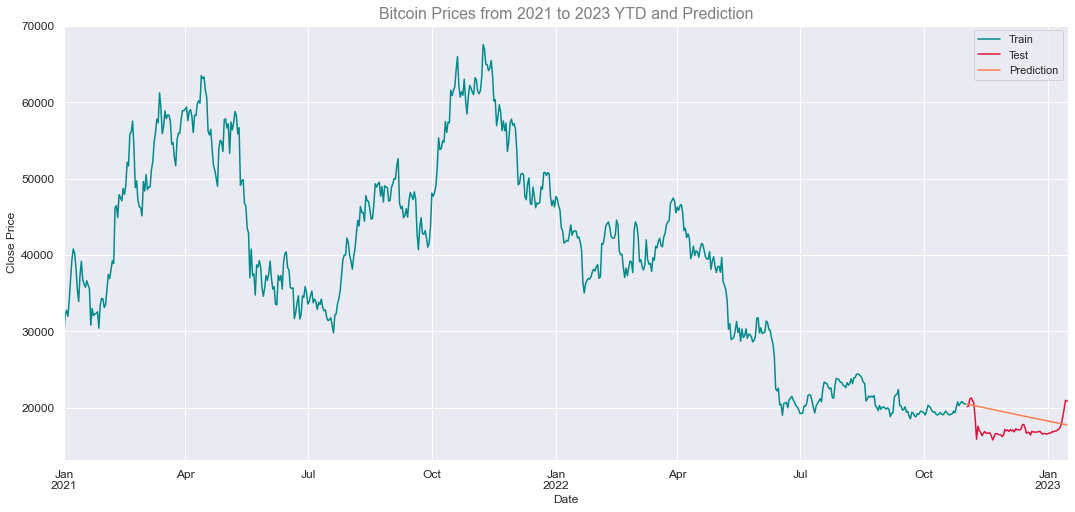

In [299]:
train_graph = train.set_index('date')
test_graph = test.set_index('date')

sns.set_theme()
train_graph.close.plot( figsize=(18,8), fontsize=12, label='Train', color='DarkCyan')
test_graph.close.plot(figsize=(18,8), fontsize=12, label='Test', color='Crimson')
forecast.close.plot(figsize=(18,8), fontsize=12, label='Prediction', color='Coral')
plt.legend()
plt.title("Bitcoin Prices from 2021 to 2023 YTD and Prediction", fontsize=16, color='Grey')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()